<a href="https://colab.research.google.com/github/bjg5091/Capstone-3-COVID-Image-Processing/blob/main/Notebooks/Capstone_3_Modeling_with_VGG19_Transfer_Learning_Rev_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

NOTE: This is the submitted model for the Capstone project. However, there are also the following models:

Three layered Sequential
VGG16
ResNet50

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import skimage.color
import skimage.filters
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import io
import cv2
import pathlib
import glob
import random 
import seaborn as sns

from keras.applications.vgg19 import preprocess_input
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from skimage.filters import gaussian
from skimage import img_as_ubyte
from google.colab import drive
from tqdm import tqdm
from google.colab import files
from PIL import Image
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


drive.mount('RadiographyDataset/')

print(tf.__version__)

Mounted at RadiographyDataset/
2.12.0


In [ ]:
#Import the libraries
import zipfile
import os

zip_ref = zipfile.ZipFile('/content/RadiographyDataset/MyDrive/RadiographyDataset.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

In [ ]:
cwd = os.getcwd()
print(cwd)

/content


In [ ]:
image_list = []
path = '/tmp/RadiographyDataset/RadiographyDataset'
data_dir = pathlib.Path(path).with_suffix('')
print(data_dir)

image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

/tmp/RadiographyDataset/RadiographyDataset
21165


In [ ]:
image_list = []
path_covid = '/tmp/RadiographyDataset/RadiographyDataset/COVID/*.*'

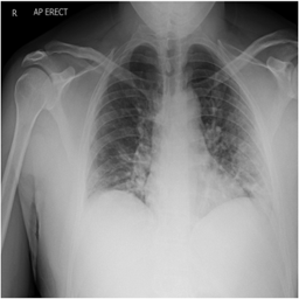

In [ ]:
covid = list(data_dir.glob('COVID/*'))
PIL.Image.open(str(covid[0]))

In [ ]:
batch_size = 32
img_height = 299
img_width = 299

In [ ]:
imagePaths = []
for dirname, _, filenames in os.walk('/tmp/RadiographyDataset/RadiographyDataset'):
    for filename in filenames:
        if (filename[-3:] == 'png'):
            imagePaths.append(os.path.join(dirname, filename))

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  label_mode='categorical',
  validation_split=0.65,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 21165 files belonging to 4 classes.
Using 7408 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  label_mode='categorical',
  validation_split=0.15,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 21165 files belonging to 4 classes.
Using 3174 files for validation.


In [ ]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_dataset = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 80
Number of test batches: 20


In [ ]:
class_names = train_ds.class_names
print(class_names)

['COVID', 'Lung_Opacity', 'Normal', 'Viral_Pneumonia']


In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 299, 299, 3)
(32, 4)


In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
preprocess_input = tf.keras.applications.vgg19.preprocess_input

In [ ]:
imsize = (299,299)

In [ ]:
# Create the base model from the pre-trained model VGG19
IMG_SHAPE = imsize + (3,)
base_model = tf.keras.applications.VGG19(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

80134624/80134624 [==============================] - 4s 0us/step


In [ ]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 9, 9, 512)


In [ ]:
base_model.trainable = False

base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 299, 299, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 299, 299, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 149, 149, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 149, 149, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 149, 149, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 74, 74, 128)       0     

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 512)


In [ ]:
prediction_layer = tf.keras.layers.Dense(4, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 4)


In [ ]:
inputs = tf.keras.Input(shape=(299, 299, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 299, 299, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 299, 299, 3)      0         
                                                                 
 vgg19 (Functional)          (None, 9, 9, 512)         20024384  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 512)               0     

In [ ]:
len(model.trainable_variables)

2

In [ ]:
base_learning_rate = 0.0001

model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['accuracy',
     tf.keras.metrics.Recall(),
     tf.keras.metrics.Precision()])

In [ ]:
es = EarlyStopping(monitor='val_accuracy', patience=3)

In [ ]:
initial_epochs = 10

In [ ]:
this_model = model.fit(train_ds, validation_data=val_ds, epochs=initial_epochs, batch_size=128, verbose=1, callbacks = [es])

Epoch 1/10


/usr/local/lib/python3.9/dist-packages/keras/backend.py:5561: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


232/232 [==============================] - 100s 396ms/step - loss: 2.4811 - accuracy: 0.3503 - recall: 0.3255 - precision: 0.3597 - val_loss: 1.3137 - val_accuracy: 0.5051 - val_recall: 0.4373 - val_precision: 0.5312
Epoch 2/10
232/232 [==============================] - 91s 394ms/step - loss: 1.5448 - accuracy: 0.5012 - recall: 0.4638 - precision: 0.5235 - val_loss: 0.9932 - val_accuracy: 0.6148 - val_recall: 0.5533 - val_precision: 0.6607
Epoch 3/10
232/232 [==============================] - 92s 396ms/step - loss: 1.2447 - accuracy: 0.5780 - recall: 0.5394 - precision: 0.6057 - val_loss: 0.8418 - val_accuracy: 0.6843 - val_recall: 0.6334 - val_precision: 0.7269
Epoch 4/10
232/232 [==============================] - 92s 395ms/step - loss: 1.0648 - accuracy: 0.6320 - recall: 0.5983 - precision: 0.6589 - val_loss: 0.7589 - val_accuracy: 0.7174 - val_recall: 0.6701 - val_precision: 0.7553
Epoch 5/10
232/232 [==============================] - 92s 396ms/step - loss: 0.9809 - accuracy: 0.6632

In [ ]:
accuracy = this_model.history['accuracy']
val_accuracy = this_model.history['val_accuracy']
loss = this_model.history['loss']
val_loss = this_model.history['val_loss']
recall = this_model.history['recall']
val_recall = this_model.history['val_recall']
precision = this_model.history['precision']
val_precision = this_model.history['val_precision']

print(np.max(val_accuracy))

0.7932122945785522


In [ ]:
epoch_range = range(1, len(accuracy)+1)

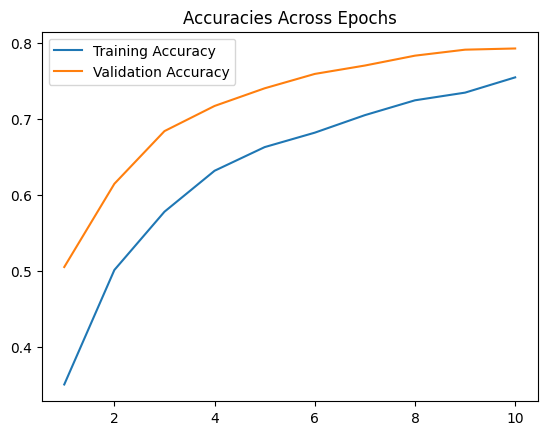

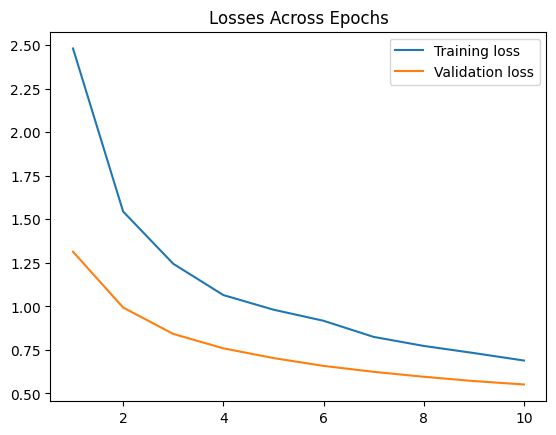

In [ ]:
plt.plot(epoch_range, accuracy, label='Training Accuracy')
plt.plot(epoch_range, val_accuracy, label='Validation Accuracy')
plt.title('Accuracies Across Epochs')
plt.legend()
plt.figure()
## saved as epochs_accuracies.png

plt.plot(epoch_range, loss,  label='Training loss')
plt.plot(epoch_range, val_loss, label='Validation loss')
plt.title('Losses Across Epochs')
plt.legend()
plt.show()        
## saved as epochs_losses.png



In [ ]:
y_pred = model.predict(val_ds)
print(class_names[np.argmax(y_pred[1])])

80/80 [==============================] - 24s 297ms/step
Lung_Opacity


In [ ]:
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 10

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  22


In [ ]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['accuracy',
     tf.keras.metrics.Recall(),
     tf.keras.metrics.Precision()])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 299, 299, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 299, 299, 3)      0         
                                                                 
 vgg19 (Functional)          (None, 9, 9, 512)         20024384  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 512)               0     

In [ ]:
len(model.trainable_variables)

20

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

model_fine = model.fit(train_ds, validation_data=val_ds, epochs=total_epochs, initial_epoch=this_model.epoch[-1], batch_size=128, verbose=1, callbacks = [es])

Epoch 10/20
232/232 [==============================] - 155s 628ms/step - loss: 0.3876 - accuracy: 0.8576 - recall_1: 0.8421 - precision_1: 0.8711 - val_loss: 0.2770 - val_accuracy: 0.8982 - val_recall_1: 0.8903 - val_precision_1: 0.9042
Epoch 11/20
232/232 [==============================] - 142s 615ms/step - loss: 0.2024 - accuracy: 0.9308 - recall_1: 0.9266 - precision_1: 0.9353 - val_loss: 0.2651 - val_accuracy: 0.8990 - val_recall_1: 0.8966 - val_precision_1: 0.9012
Epoch 12/20
232/232 [==============================] - 143s 615ms/step - loss: 0.1344 - accuracy: 0.9534 - recall_1: 0.9505 - precision_1: 0.9557 - val_loss: 0.1979 - val_accuracy: 0.9282 - val_recall_1: 0.9262 - val_precision_1: 0.9302
Epoch 13/20
232/232 [==============================] - 143s 616ms/step - loss: 0.1024 - accuracy: 0.9637 - recall_1: 0.9630 - precision_1: 0.9647 - val_loss: 0.2111 - val_accuracy: 0.9254 - val_recall_1: 0.9238 - val_precision_1: 0.9260
Epoch 14/20
232/232 [==============================]

In [ ]:
accuracy += model_fine.history['accuracy']
val_accuracy += model_fine.history['val_accuracy']

loss += model_fine.history['loss']
val_loss += model_fine.history['val_loss']

recall += model_fine.history['recall_1']
val_recall += model_fine.history['val_recall_1']

precision += model_fine.history['precision_1']
val_precision += model_fine.history['val_precision_1']

In [ ]:
print("val_accuracy:", np.max(val_accuracy))
print("val_recall:", np.max(val_recall))
print("val_precision:", np.max(val_precision))

val_accuracy: 0.9352802038192749
val_recall: 0.9352802038192749
val_precision: 0.9367588758468628


In [ ]:
final_loss, final_accuracy, final_recall, final_precision = model.evaluate(val_ds)

80/80 [==============================] - 23s 293ms/step - loss: 0.2490 - accuracy: 0.9250 - recall_1: 0.9246 - precision_1: 0.9272


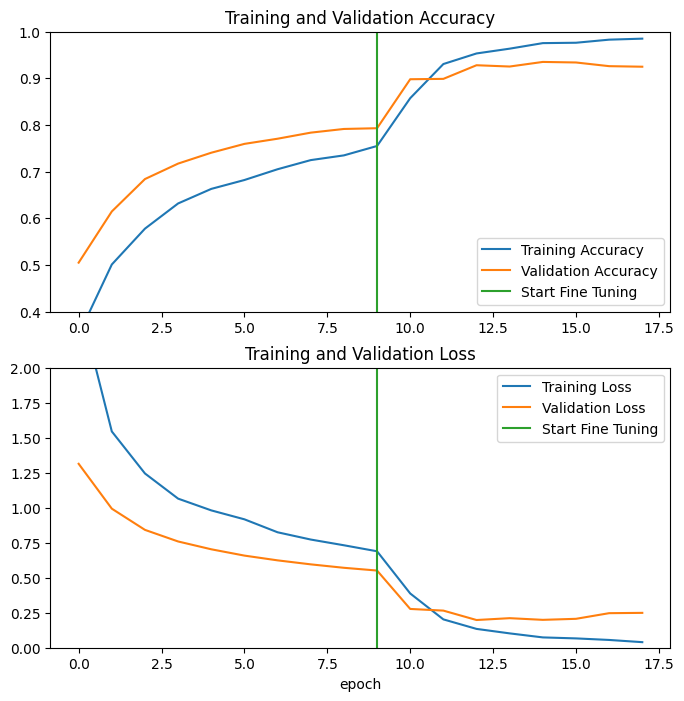

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.ylim([0.4, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 2.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, accuracy, recall, precision = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

20/20 [==============================] - 6s 297ms/step - loss: 0.2882 - accuracy: 0.9203 - recall_1: 0.9203 - precision_1: 0.9203
Test accuracy : 0.9203125238418579


In [ ]:
f1 = 2*final_precision*final_recall/(final_precision + final_recall)

print("F1 score: ", f1)

F1 score:  0.9259039630322572


In [ ]:
y_pred = model.predict(val_ds)
print(class_names[np.argmax(y_pred[1])])

80/80 [==============================] - 23s 292ms/step
Lung_Opacity


In [ ]:
predicted_categories = np.argmax(y_pred, axis = 1)

In [ ]:
true_categories = tf.concat([y for x, y in val_ds], axis = 0).numpy() # convert to np array

In [ ]:
true_categories_argmax = np.argmax(true_categories, axis = 1)

In [ ]:
print(classification_report(true_categories_argmax, predicted_categories))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       427
           1       0.85      0.95      0.90       712
           2       0.97      0.89      0.92      1223
           3       0.94      0.97      0.96       172

    accuracy                           0.93      2534
   macro avg       0.93      0.95      0.94      2534
weighted avg       0.93      0.93      0.93      2534



In [ ]:
prediction_classes = np.array([])
true_classes =  np.array([])

for x, y in val_ds:
  prediction_classes = np.concatenate([prediction_classes,
                       np.argmax(model.predict(x), axis = -1)])
  true_classes = np.concatenate([true_classes, np.argmax(y.numpy(), axis=-1)])

1/1 [==============================] - 0s 155ms/step


In [ ]:
print(classification_report(true_classes, prediction_classes))

              precision    recall  f1-score   support

         0.0       0.95      0.97      0.96       427
         1.0       0.85      0.95      0.90       712
         2.0       0.97      0.89      0.92      1223
         3.0       0.94      0.97      0.96       172

    accuracy                           0.93      2534
   macro avg       0.93      0.95      0.94      2534
weighted avg       0.93      0.93      0.93      2534



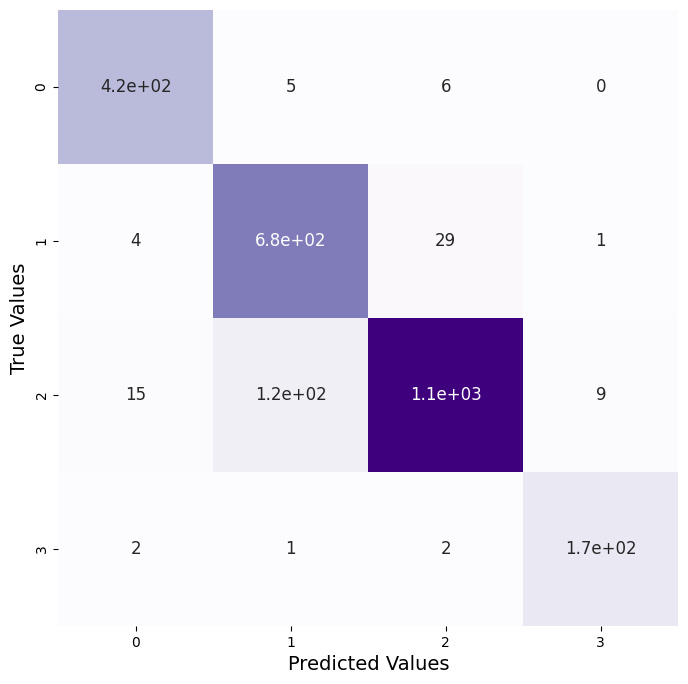

In [ ]:
cm = confusion_matrix(true_classes, prediction_classes)
fig = plt.figure(figsize = (8,8))
ax1 = fig.add_subplot(1,1,1)
sns.set(font_scale=1.4) #for label size
sns.heatmap(cm, annot=True, annot_kws={"size": 12},
     cbar = False, cmap='Purples');
ax1.set_ylabel('True Values',fontsize=14)
ax1.set_xlabel('Predicted Values',fontsize=14)
plt.show()

After testing on multiple models including VGG16 and ResNet50 for Transfer Learning, it was determined that VGG19 was giving the best results for accuracy related to this dataset. We used half the dataset (over 10,000 images) and divided it into training, validation and test subsets. This dataset consists of four different categories of lung X-rays: Normal (most common), COPD, COVID, Pneumonia (least common).

We then finetuned the model, ensuring that it did not overfit and that early stopping would be used with a learning rate of 0.0001 and then 0.00001 in the trainable model fit. The final results were as followed:

Validation Accuracy: 0.9353

Validation Recall: 0.9353

Validation Precision: 0.9368

Validation F1 Score: 0.9259

Test Accuracy: 0.9203

